In [11]:
from utils.self_preference_analyzer import Config, AnalyzeDataLoader, PlotUtils, QualitativeEvaluator
import matplotlib.pyplot as plt 
import pandas as pd
from typing import Dict, List, Optional, Union, Tuple
import numpy as np
import os

In [12]:
class LanguageAnalyzer:
    """Class for language-based analysis and visualization."""
    
    def __init__(self, config: Config, plot_utils: PlotUtils):
        self.config = config
        self.plot_utils = plot_utils
    
    def plot_wins_by_language(self, df: pd.DataFrame, experiment_type: str = "all") -> None:
        """Plot wins by language across all models."""
        # Filter and group data
        if experiment_type == "all":
            grouped_df = df.groupby('native_language')[self.config.WIN_TYPES].sum()
        else:
            filtered_df = df[df['experiment'] == experiment_type]
            grouped_df = filtered_df.groupby('native_language')[self.config.WIN_TYPES].sum()
        
        # Calculate percentages
        grouped_df = self.plot_utils.calculate_percentages(grouped_df, self.config.WIN_TYPES)
        
        # Ensure proper language ordering
        grouped_df = grouped_df.reindex(self.config.SORTED_LANGUAGES_BY_RESOURCE)
        
        # Create plot
        fig, ax = plt.subplots(figsize=self.config.FIGURE_SIZE)
        self.plot_utils.setup_bar_plot(
            ax, grouped_df,
            f'Percentage of Wins by Language ({experiment_type})',
            'Language', self.config.WIN_TYPES, self.config.BAR_WIDTH
        )
        
        ax.set_xticklabels(grouped_df.index, rotation=90)
        plt.tight_layout()
        plt.show()
    
    def plot_wins_by_language_per_model(self, df: pd.DataFrame, experiment_type: str = "all") -> None:
        """Plot wins by language for each model separately."""
        # Filter and group data
        if experiment_type == "all":
            grouped_df = df.groupby(['native_language', 'model'])[self.config.WIN_TYPES].sum().reset_index()
        else:
            filtered_df = df[df['experiment'] == experiment_type]
            grouped_df = filtered_df.groupby(['native_language', 'model'])[self.config.WIN_TYPES].sum().reset_index()
        
        # Calculate percentages
        grouped_df = self.plot_utils.calculate_percentages(grouped_df, self.config.WIN_TYPES)
        
        # Ensure proper language ordering
        grouped_df['native_language'] = pd.Categorical(
            grouped_df['native_language'], 
            categories=self.config.SORTED_LANGUAGES_BY_RESOURCE, 
            ordered=True
        )
        
        models = grouped_df['model'].unique()
        
        # Create separate plot for each model
        for model in models:
            model_df = grouped_df[grouped_df['model'] == model].sort_values('native_language')
            
            if len(model_df) == 0:
                continue
                
            # Create plot
            fig, ax = plt.subplots(figsize=self.config.FIGURE_SIZE)
            self.plot_utils.setup_bar_plot(
                ax, model_df,
                f'Percentage of Wins by Language for Model: {model} ({experiment_type})',
                'Language', self.config.WIN_TYPES, self.config.BAR_WIDTH
            )
            
            ax.set_xticklabels(model_df['native_language'], rotation=90)
            plt.tight_layout()
            plt.show()
    
    def plot_wins_grouped_by_model(self, df: pd.DataFrame, model_list: List[str], experiment_type: str = "all") -> None:
        """Plot wins comparison for specific models grouped together."""
        # Filter data by experiment type and selected models
        if experiment_type == "all":
            filtered_df = df[df['model'].isin(model_list)]
        else:
            filtered_df = df[(df['experiment'] == experiment_type) & (df['model'].isin(model_list))]
        
        if len(filtered_df) == 0:
            print(f"No data found for models {model_list} in experiment type '{experiment_type}'")
            return
        
        # Group by language and model
        grouped_df = filtered_df.groupby(['native_language', 'model'])[self.config.WIN_TYPES].sum().reset_index()
        
        # Calculate percentages
        grouped_df = self.plot_utils.calculate_percentages(grouped_df, self.config.WIN_TYPES)
        
        # Ensure proper language ordering
        grouped_df['native_language'] = pd.Categorical(
            grouped_df['native_language'], 
            categories=self.config.SORTED_LANGUAGES_BY_RESOURCE, 
            ordered=True
        )
        
        # Sort by language
        grouped_df = grouped_df.sort_values(['native_language', 'model'])
        
        # Create subplot layout
        n_models = len(model_list)
        fig, axes = plt.subplots(1, n_models, figsize=(self.config.FIGURE_SIZE[0] * n_models * 0.8, self.config.FIGURE_SIZE[1]))
        
        # Ensure axes is always a list
        if n_models == 1:
            axes = [axes]
        
        # Plot each model
        for i, model in enumerate(model_list):
            model_df = grouped_df[grouped_df['model'] == model]
            
            if len(model_df) == 0:
                axes[i].text(0.5, 0.5, f'No data for\n{model}', 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'{model}')
                continue
            
            # Set up the bar plot for this model
            self.plot_utils.setup_bar_plot(
                axes[i], model_df,
                f'{model}',
                'Language', self.config.WIN_TYPES, self.config.BAR_WIDTH
            )
            
            axes[i].set_xticklabels(model_df['native_language'], rotation=90)
            
            # Only show y-label on the first subplot
            if i > 0:
                axes[i].set_ylabel('')
        
        # Add overall title
        fig.suptitle(f'Language Performance Comparison - {experiment_type}', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

In [13]:
config = Config()
plot_utils = PlotUtils()
language_analyzer = LanguageAnalyzer(config, plot_utils)

In [14]:
# Initialize data loader
data_loader = AnalyzeDataLoader(config)
dataframes = data_loader.prepare_data()

# Extract individual dataframes for easier access
concept_df = dataframes['concept']
country_df = dataframes['country'] 
overall_df = dataframes['overall']
language_df = dataframes['language']

## Overall performance for each country

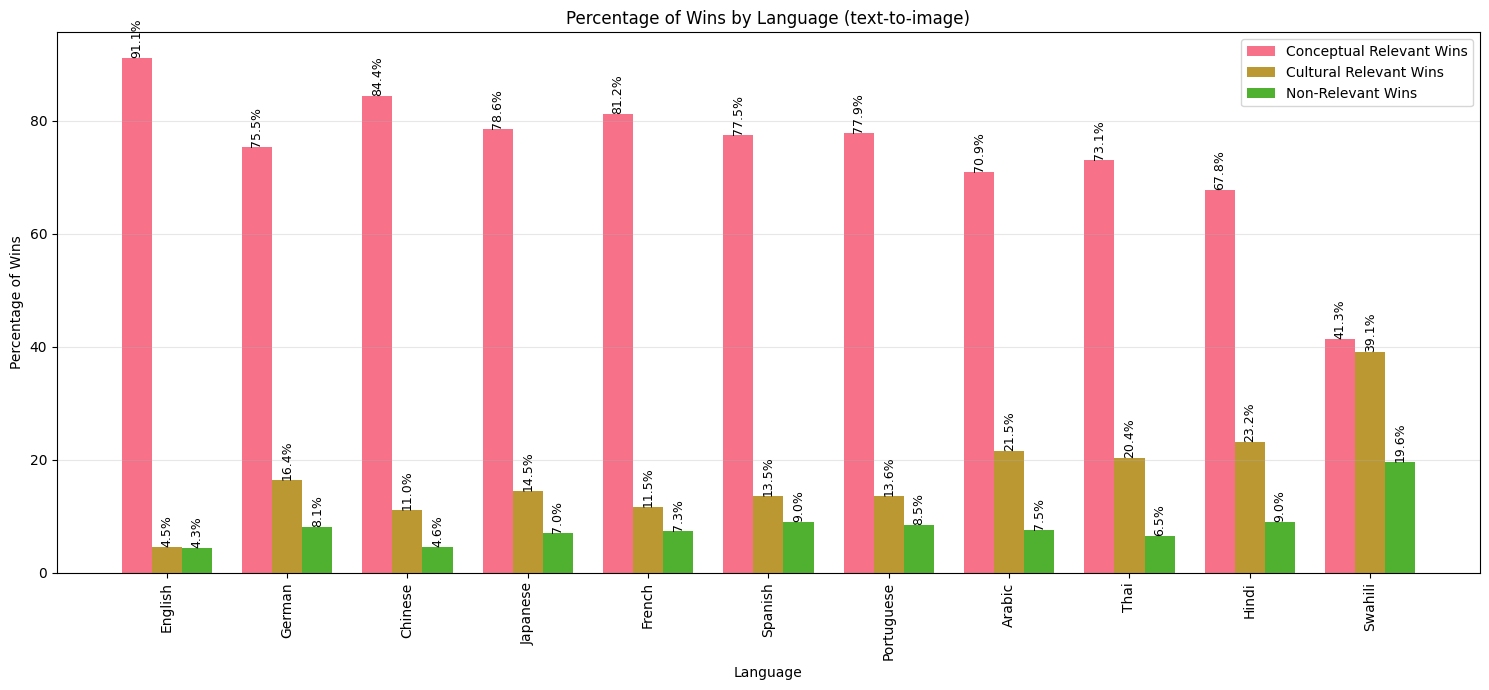

In [15]:
language_analyzer.plot_wins_by_language(language_df, 'text-to-image')

## Performance for each country on each model

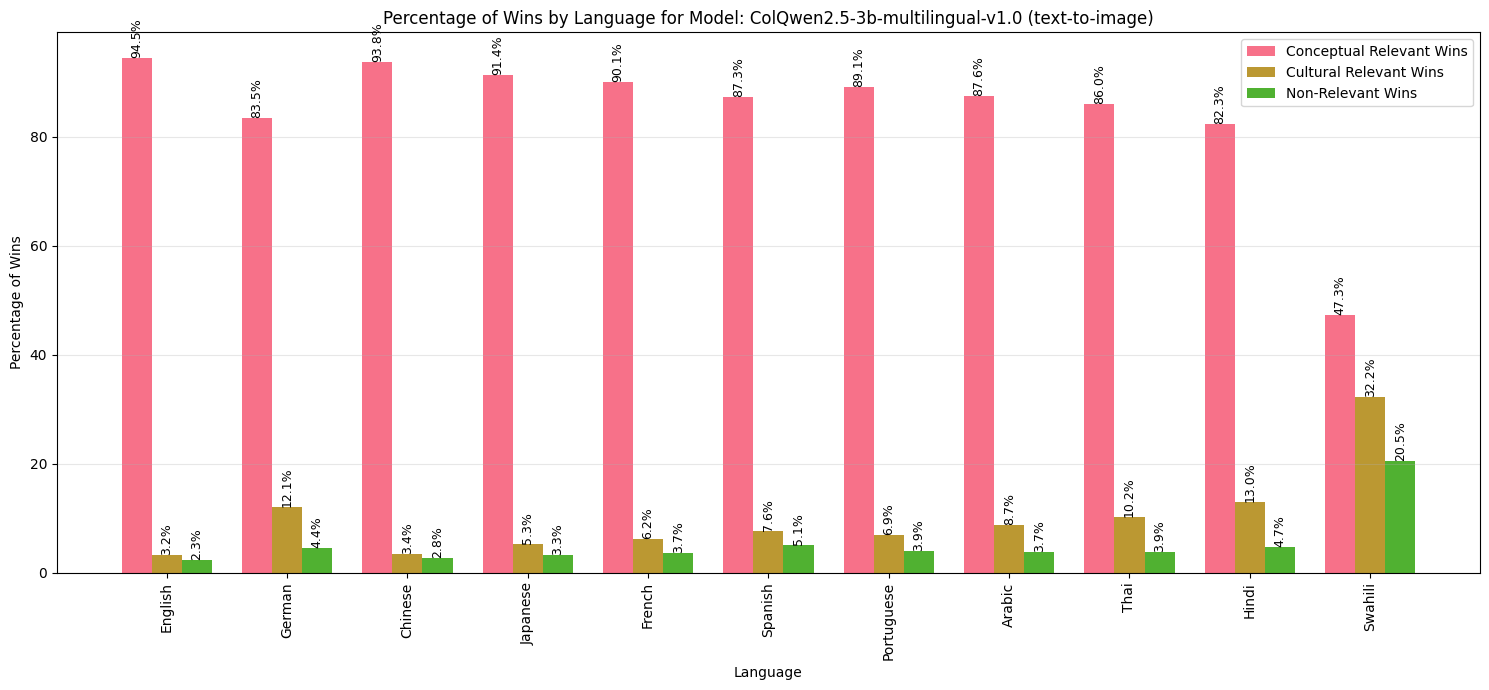

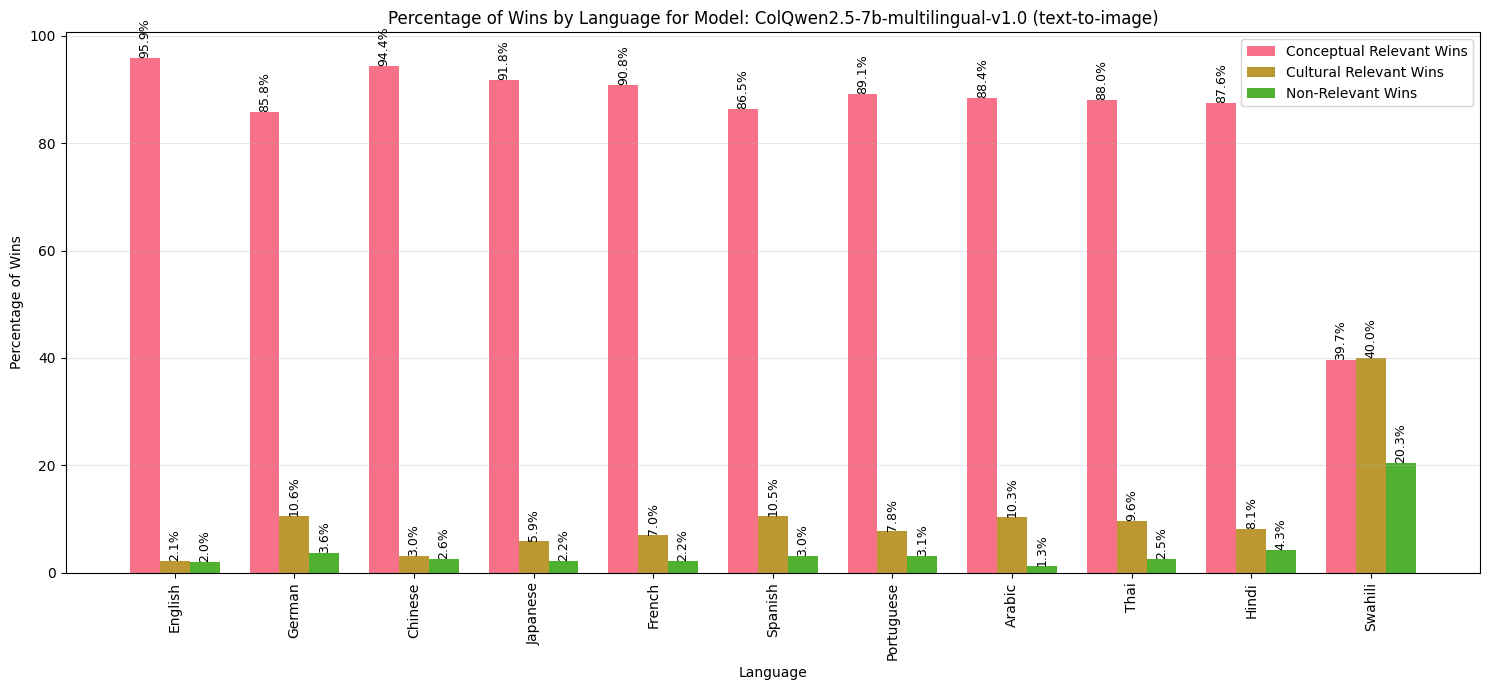

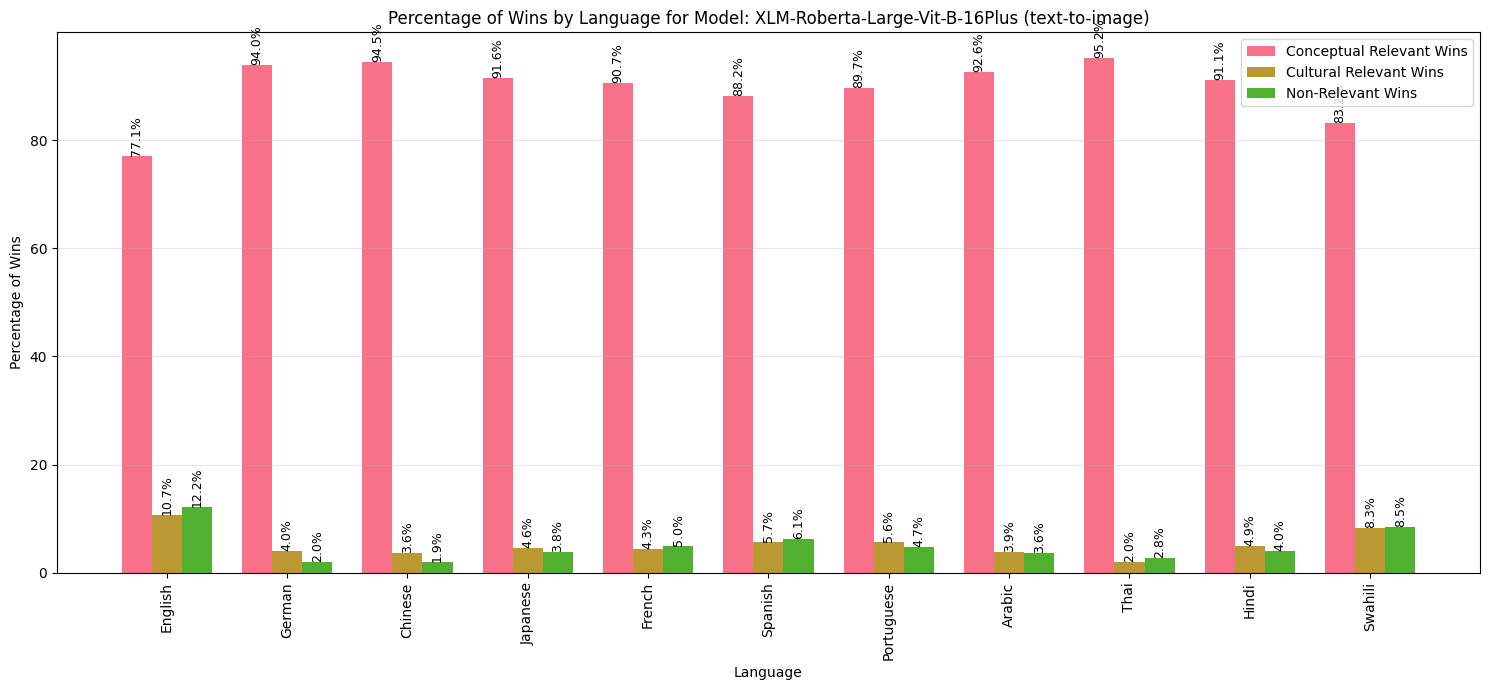

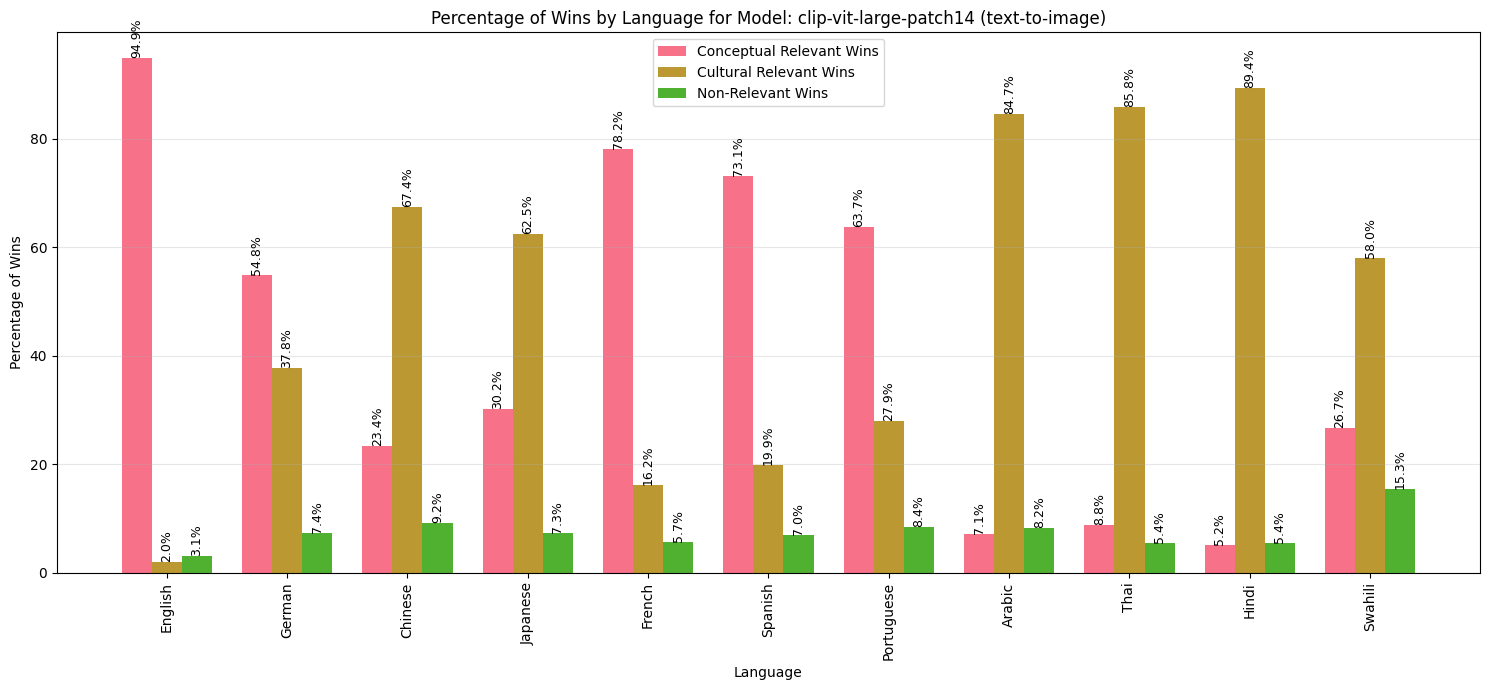

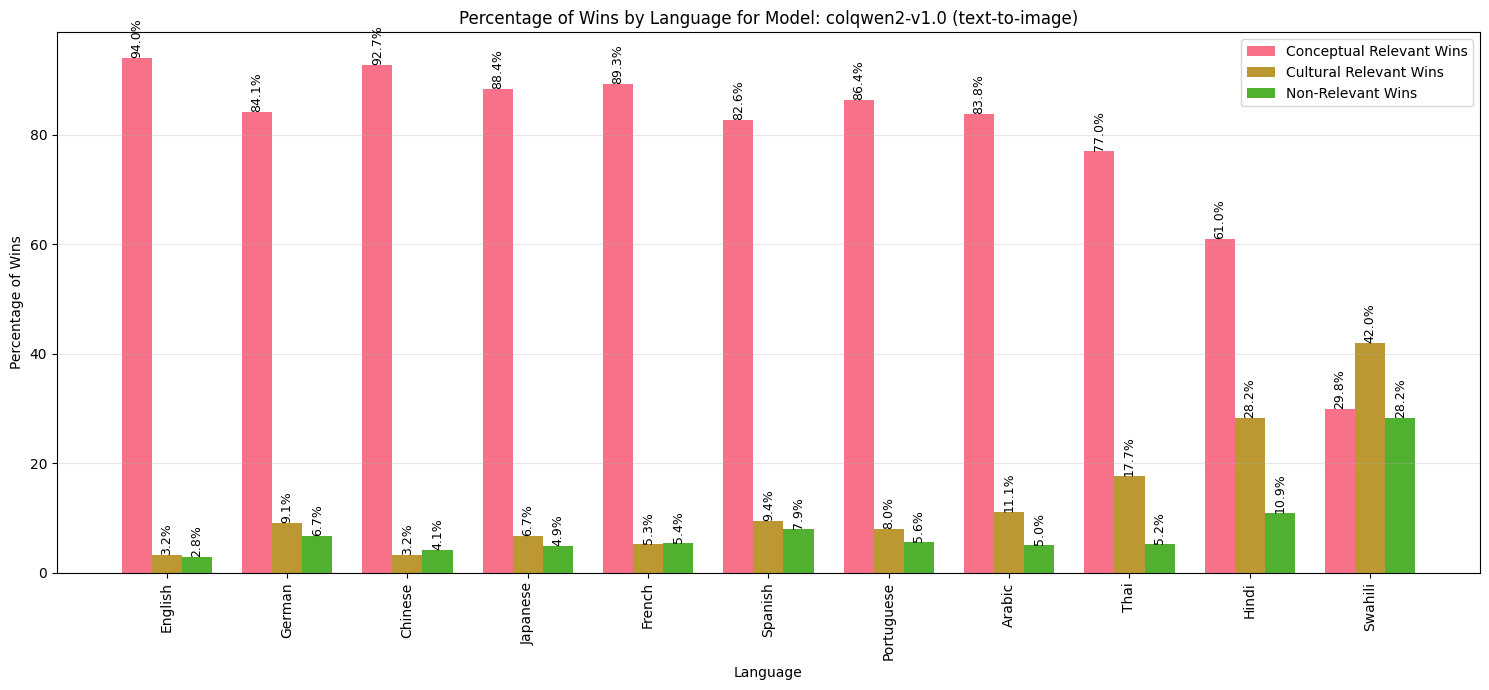

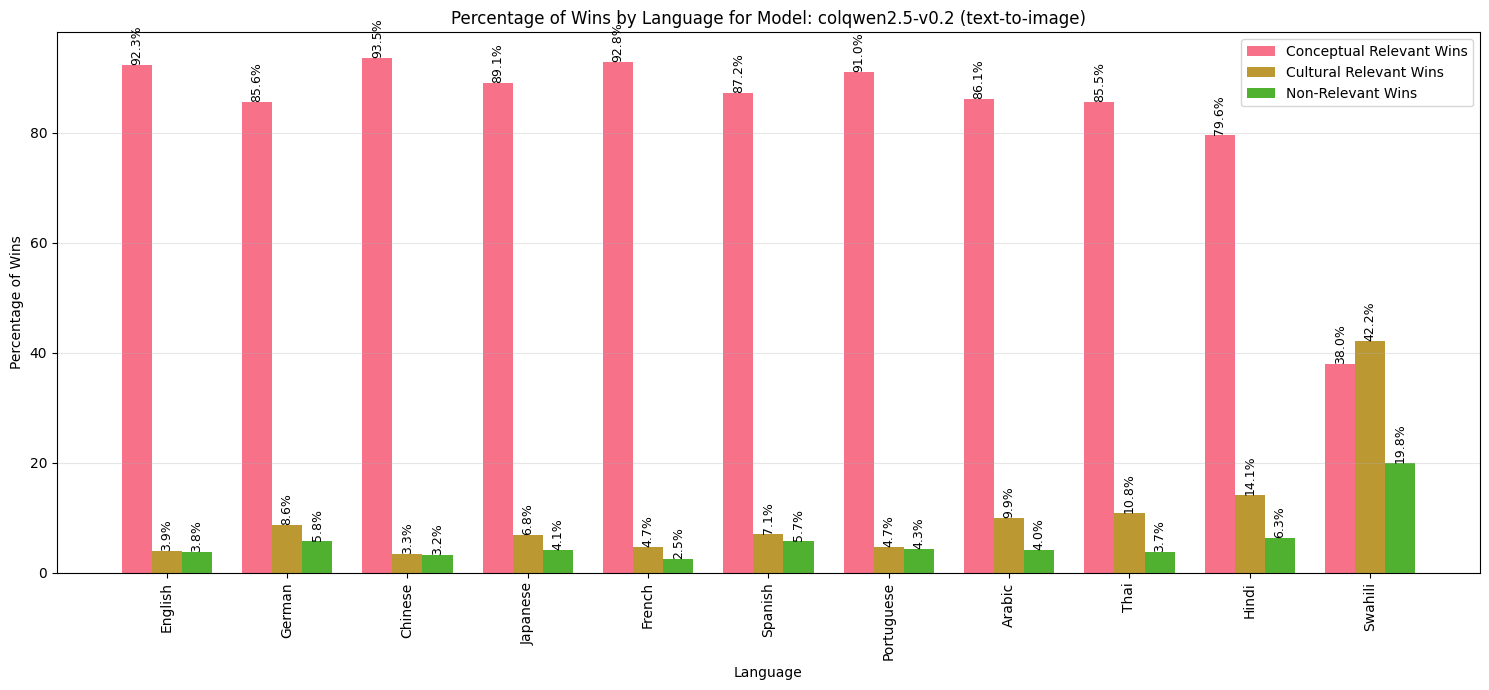

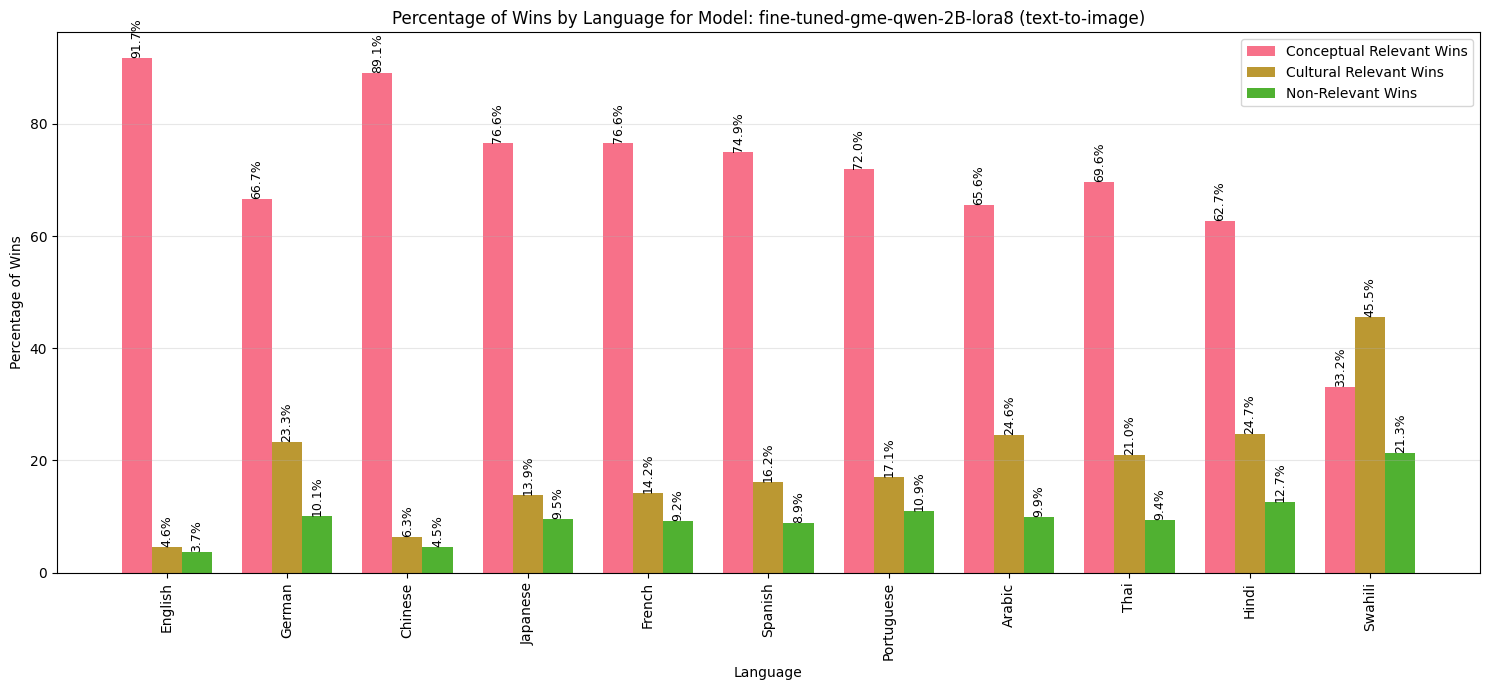

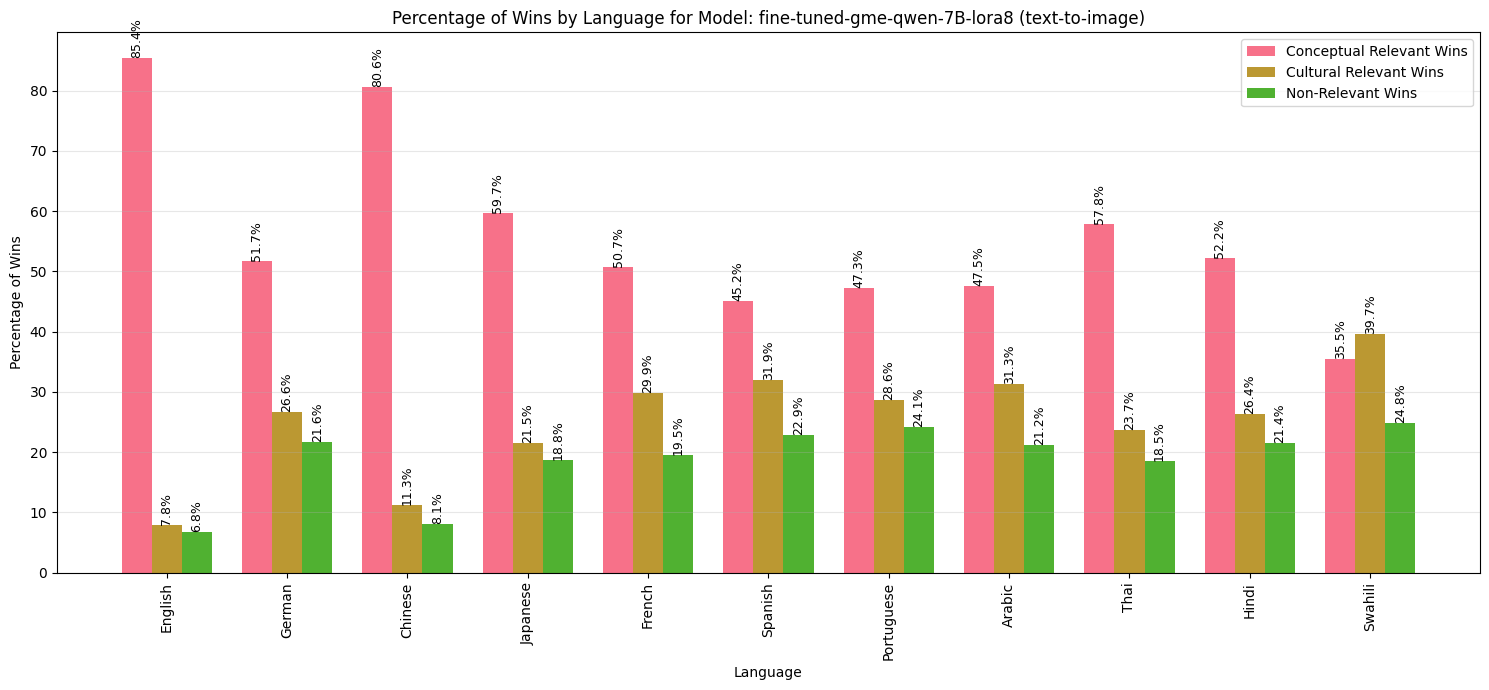

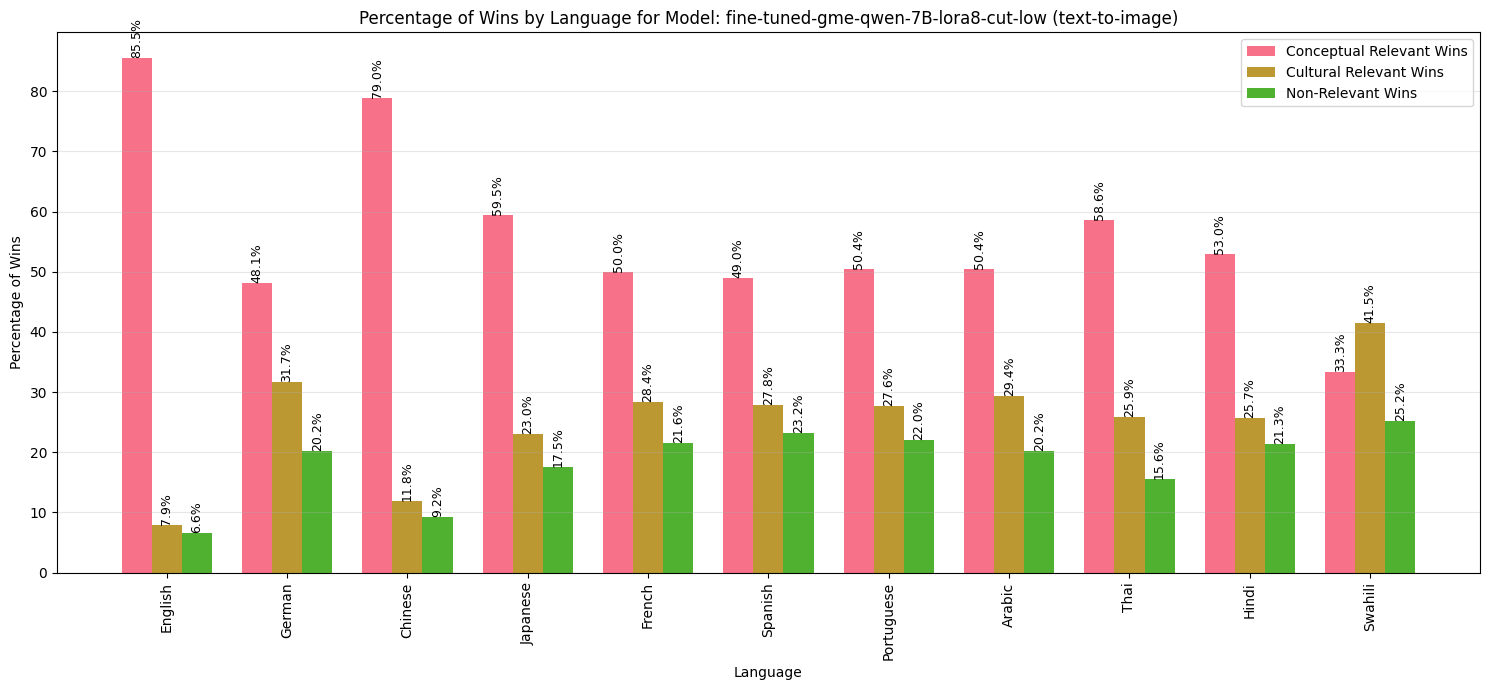

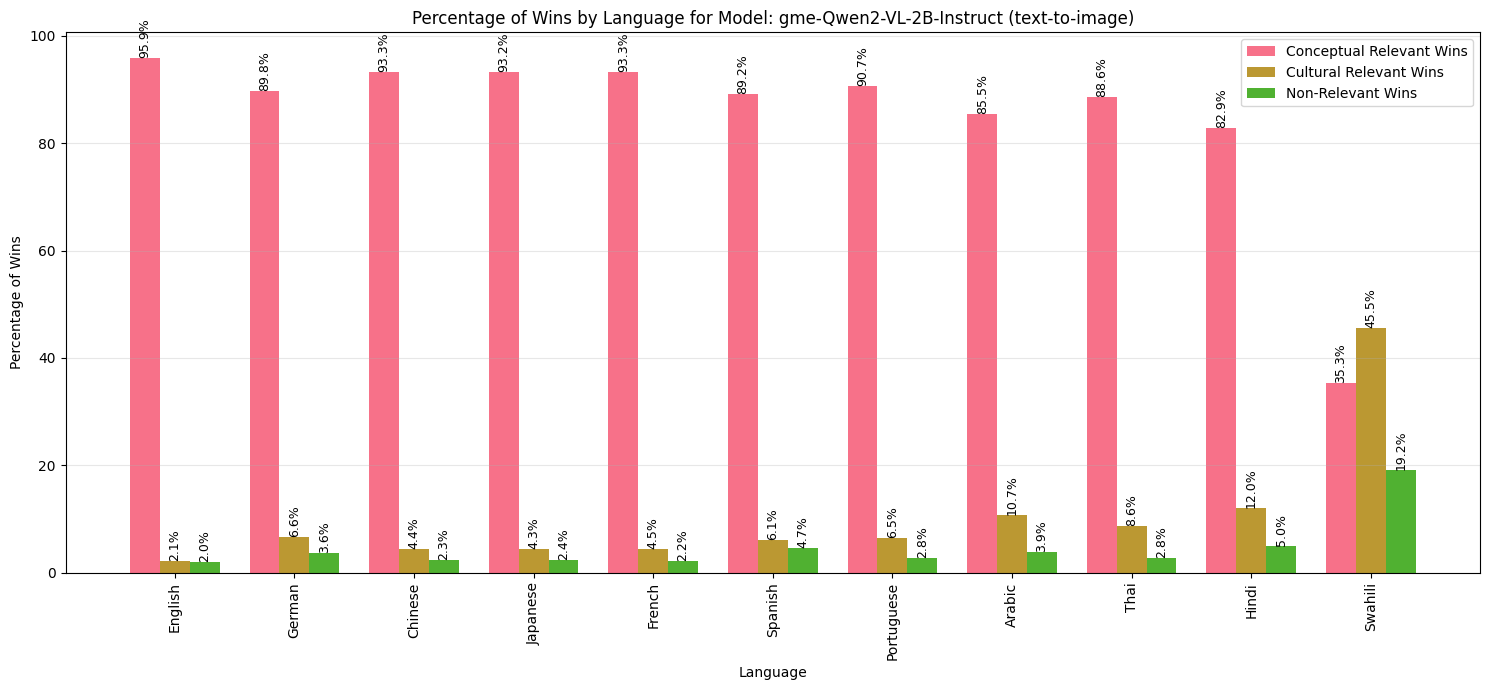

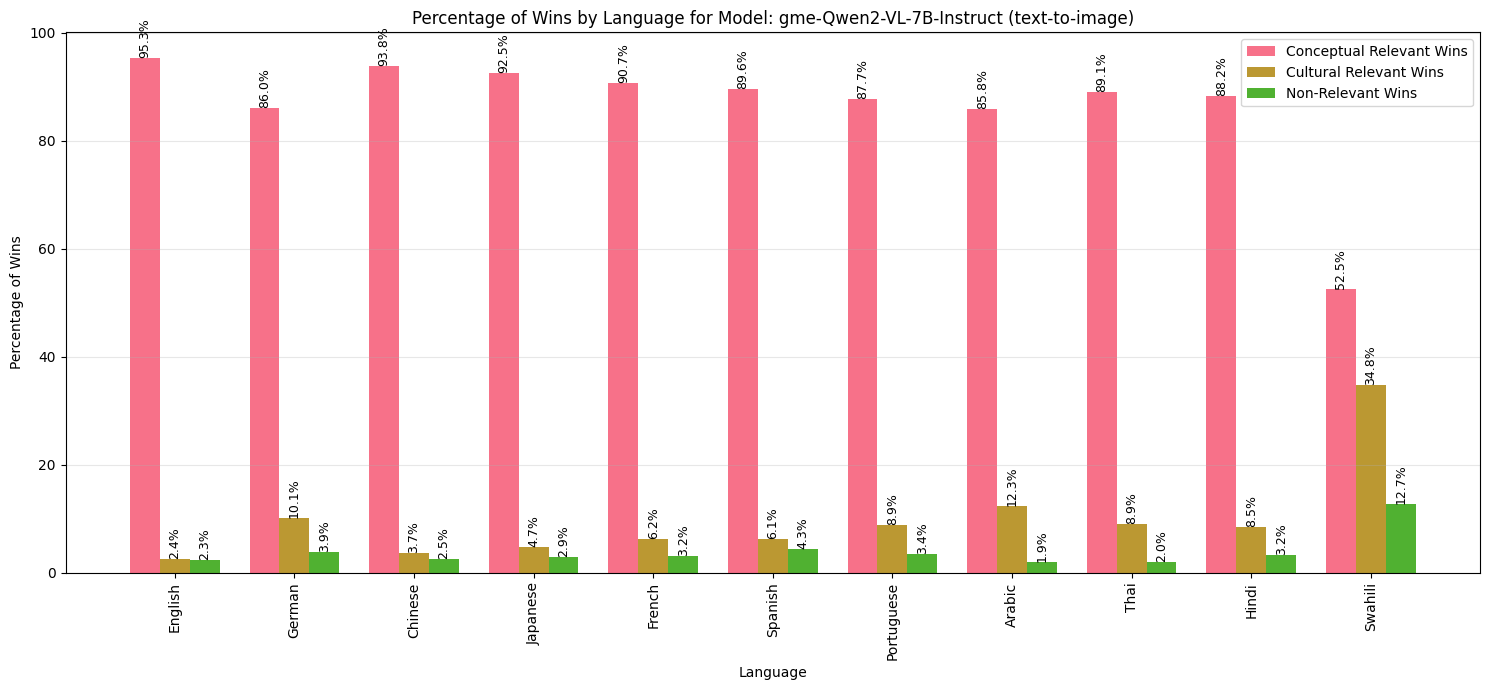

In [16]:

language_analyzer.plot_wins_by_language_per_model(language_df, 'text-to-image')

## Pretrain vs Fine-Tune

#### GME

In [17]:
country_df['model'].unique()

array(['clip-vit-large-patch14', 'colqwen2-v1.0',
       'ColQwen2.5-3b-multilingual-v1.0',
       'ColQwen2.5-7b-multilingual-v1.0', 'colqwen2.5-v0.2',
       'fine-tuned-gme-qwen-2B-lora8',
       'fine-tuned-gme-qwen-7B-lora8-cut-low',
       'fine-tuned-gme-qwen-7B-lora8', 'gme-Qwen2-VL-2B-Instruct',
       'gme-Qwen2-VL-7B-Instruct', 'XLM-Roberta-Large-Vit-B-16Plus'],
      dtype=object)

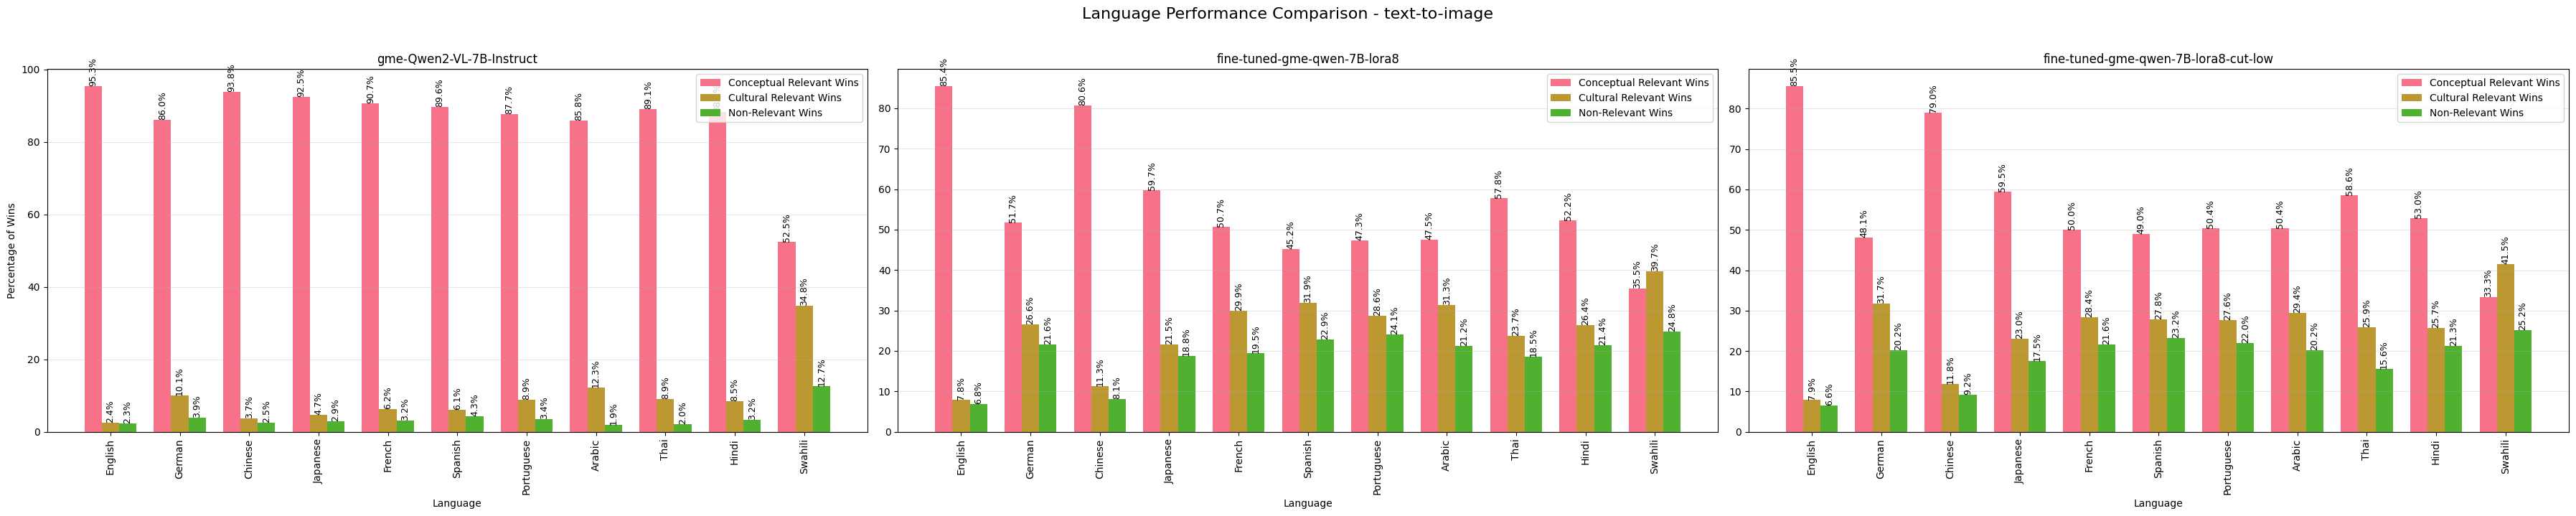

In [18]:
language_analyzer.plot_wins_grouped_by_model(language_df, ['gme-Qwen2-VL-7B-Instruct', 'fine-tuned-gme-qwen-7B-lora8', 'fine-tuned-gme-qwen-7B-lora8-cut-low'], 'text-to-image')

#### CLIP

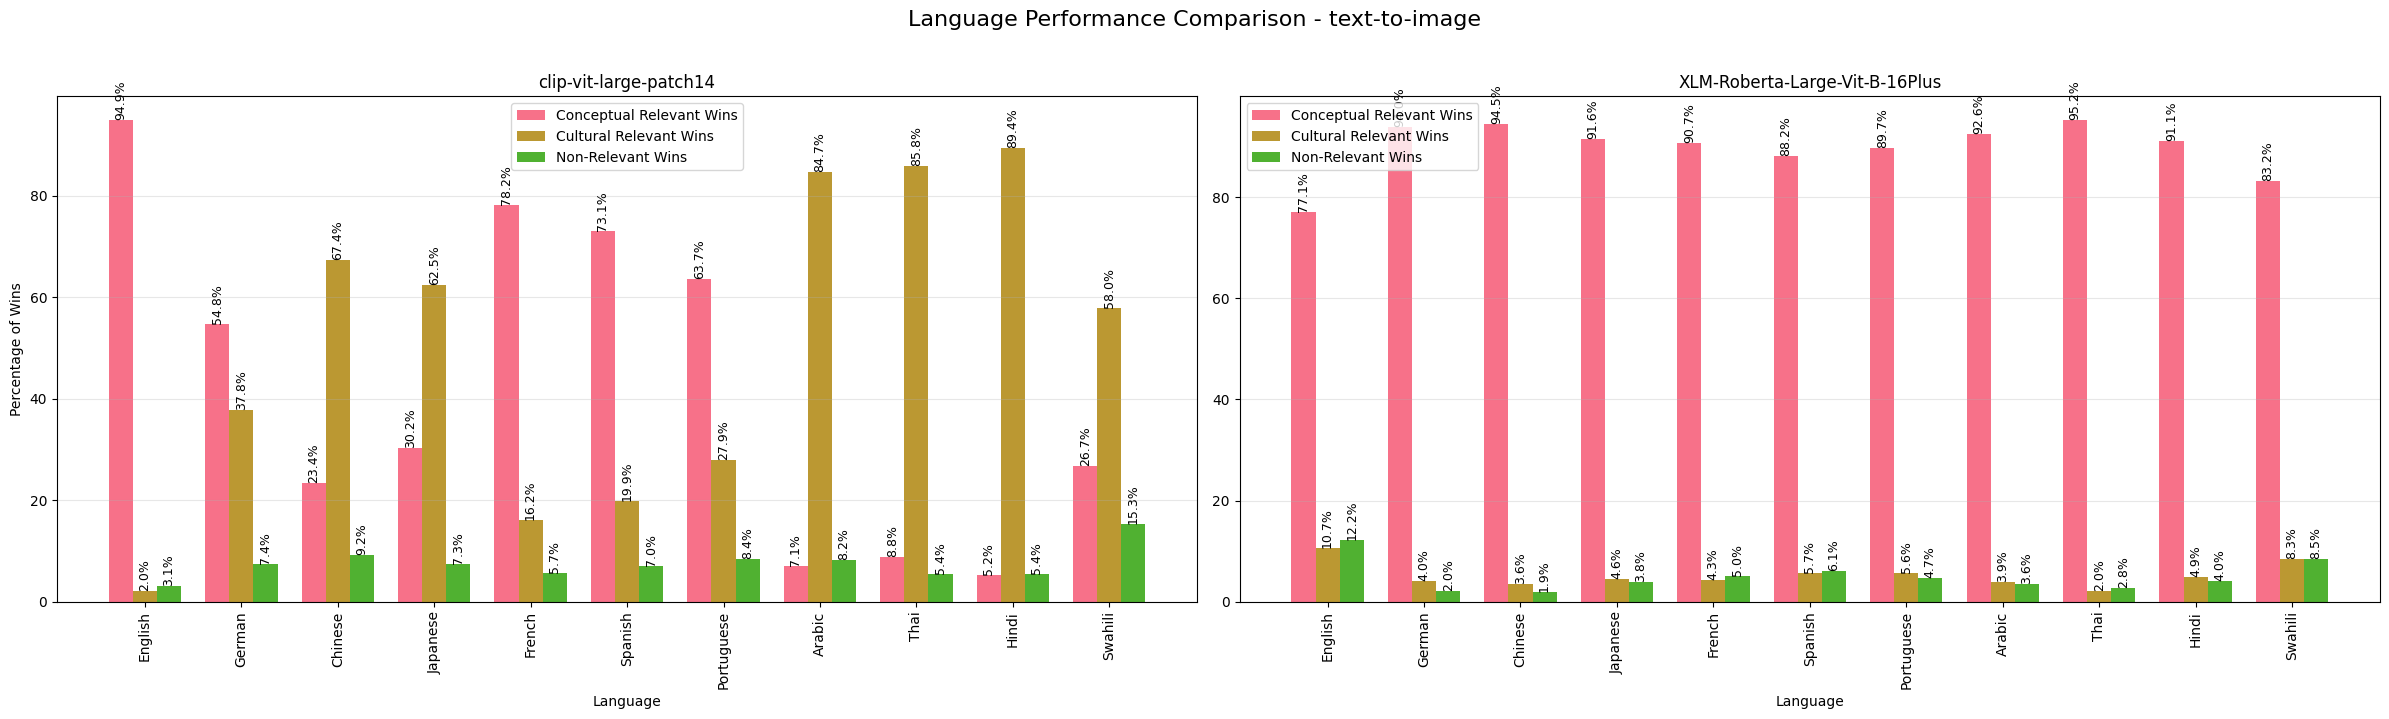

In [20]:
language_analyzer.plot_wins_grouped_by_model(language_df, ['clip-vit-large-patch14', 'XLM-Roberta-Large-Vit-B-16Plus'], 'text-to-image')